# EVALUATE MODEL TEST SET

Classification Report:
                    precision    recall  f1-score   support

           0-No DR       0.78      0.97      0.86      5162
            1-Mild       0.00      0.00      0.00       489
        2-Moderate       0.43      0.21      0.28      1059
          3-Severe       0.41      0.07      0.12       175
4-Proliferative DR       0.47      0.19      0.27       141

          accuracy                           0.75      7026
         macro avg       0.42      0.29      0.31      7026
      weighted avg       0.66      0.75      0.69      7026

Confusion Matrix:


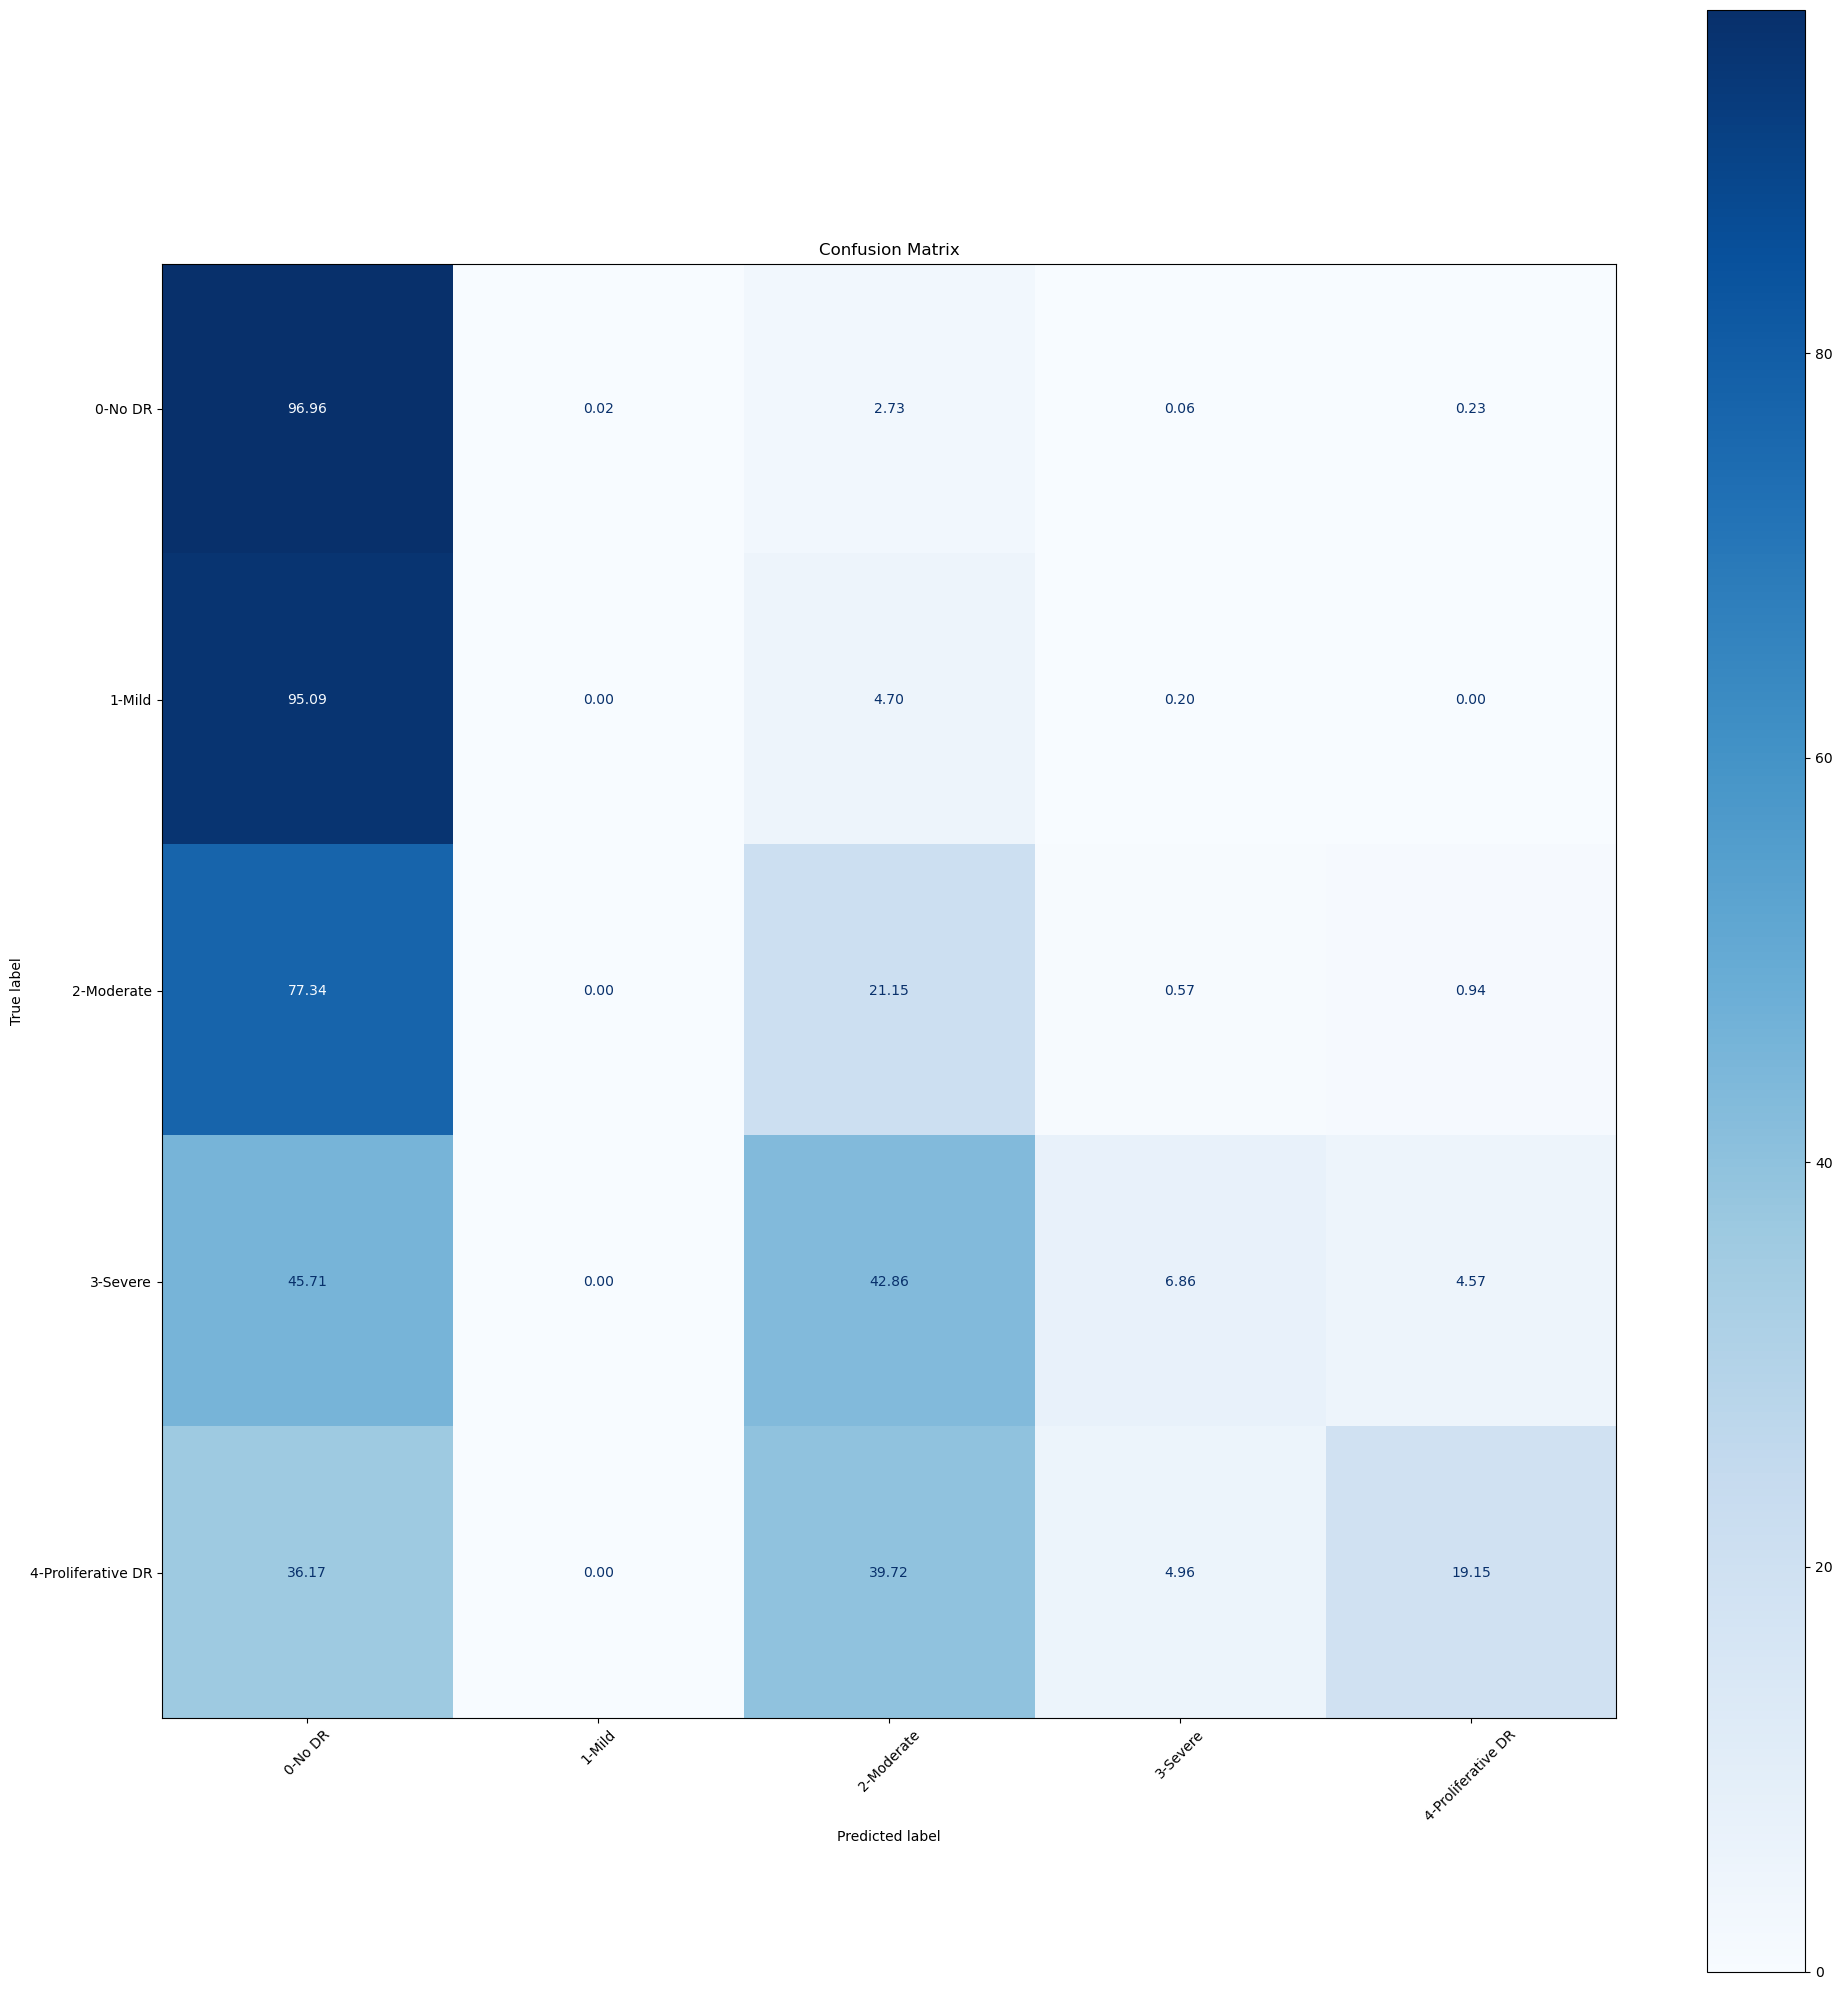

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, confusion_matrix

DESC = 'resnet'
LABELS_MAP = ['0-No DR', '1-Mild', '2-Moderate', '3-Severe', '4-Proliferative DR']
NUM_CLASSES = len(LABELS_MAP)

y_true = np.load(f'../results/{DESC}/test_results.npz')['y_true']
y_pred = np.load(f'../results/{DESC}/test_results.npz')['y_pred']

print('Classification Report:')
print(classification_report(y_true, y_pred, labels=range(NUM_CLASSES), target_names=LABELS_MAP, zero_division=0))

print('Confusion Matrix:')
cm = 100*confusion_matrix(y_true, y_pred, labels=range(NUM_CLASSES), normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=LABELS_MAP)
# plot on large figure
fig, ax = plt.subplots(figsize=(20,20))
disp.plot(xticks_rotation = 45, values_format = '.2f', ax=ax, cmap='Blues')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()

# OLD: load datasets and get model predicitions

In [8]:
# # load trained model/datasets

# import torch
# import numpy as np
# import pandas as pd

# DESC = 'resnet_random'
# DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# trained_model = torch.load(f'../results/{DESC}/model.pth', weights_only=False).to(DEVICE)
# metadata = torch.load(f'../results/{DESC}/metadata.pt', weights_only=False)
# print(metadata.keys())

# labels = pd.read_csv('../data/trainLabels.csv')
# NUM_CLASSES = len(labels['level'].unique())
# LABELS_MAP = ['0-No DR', '1-Mild', '2-Moderate', '3-Severe', '4-Proliferative DR']
# BATCH_SIZE = 32

# test_data = metadata['test_data']
# test_loader = torch.utils.data.DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False)

# trained_model.eval()
# y_true = []
# y_pred = []
# with torch.no_grad():
#     for i, (inputs, labels) in enumerate(test_loader):
#         inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
#         outputs = trained_model(inputs)
#         y_true.extend(labels.cpu().numpy())
#         y_pred.extend(torch.softmax(outputs, dim=1).argmax(dim=1).cpu().numpy())

# y_true = np.array(y_true)
# y_pred = np.array(y_pred)
# np.savez(f'../results/{DESC}/test_results.npz', y_true=y_true, y_pred=y_pred)